## MIDS W207 Final Project: Home Price Prediction

### Import packages

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr

### Load data 

In [19]:
df = pd.read_csv('../MIDS_W207_Final_Project/data/train.csv')

In [20]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
df.shape

(1460, 81)

### Split data into train and dev set

In [48]:
train_y = df[:1000]['SalePrice']
dev_y = df[1000:]['SalePrice']
train_data = df[:1000].drop(['SalePrice', 'Id'], axis = 1)
dev_data = df[1000:].drop(['SalePrice', 'Id'], axis = 1)

In [49]:
train_y.shape

(1000,)

In [50]:
dev_y.shape

(460,)

In [51]:
train_data.shape

(1000, 79)

In [52]:
dev_data.shape

(460, 79)

### EDA and data cleaning

In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 79 columns):
MSSubClass       1000 non-null int64
MSZoning         1000 non-null object
LotFrontage      827 non-null float64
LotArea          1000 non-null int64
Street           1000 non-null object
Alley            65 non-null object
LotShape         1000 non-null object
LandContour      1000 non-null object
Utilities        1000 non-null object
LotConfig        1000 non-null object
LandSlope        1000 non-null object
Neighborhood     1000 non-null object
Condition1       1000 non-null object
Condition2       1000 non-null object
BldgType         1000 non-null object
HouseStyle       1000 non-null object
OverallQual      1000 non-null int64
OverallCond      1000 non-null int64
YearBuilt        1000 non-null int64
YearRemodAdd     1000 non-null int64
RoofStyle        1000 non-null object
RoofMatl         1000 non-null object
Exterior1st      1000 non-null object
Exterior2nd      1000 non-nu

#### Identify missing data

In [54]:
# Identify the missing data and calculate the percentage by column.
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,998,0.998
MiscFeature,957,0.957
Alley,935,0.935
Fence,806,0.806
FireplaceQu,478,0.478
LotFrontage,173,0.173
GarageType,56,0.056
GarageFinish,56,0.056
GarageQual,56,0.056
GarageCond,56,0.056


#### Noticing that there are a few columns with non-trivial fraction (> 5%, arbitrary) of  missing data, we decide not to include them for further analysis.

In [55]:
cols_to_delete = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual']
train_data= train_data.drop(columns = cols_to_delete)
dev_data = dev_data.drop(columns = cols_to_delete)

In [56]:
train_data.shape

(1000, 68)

In [57]:
dev_data.shape

(460, 68)

#### For the other columns with trivial fraction of missing data, we decide to fix them in the follwing way.

In [58]:
# all missing values for the categorical columns will be replaced by "None"
# all missing values for the numeric columns will be replaced by median of that field

for col in train_data.columns:
    if train_data[col].dtypes == 'O':
        train_data[col] = train_data[col].replace(np.nan,"None")
    else:
        train_data[col] = train_data[col].replace(np.nan,train_data[col].median())

for col in dev_data.columns:
    if dev_data[col].dtypes == 'O':
        dev_data[col] = dev_data[col].replace(np.nan,"None")
    else:
        dev_data[col] = dev_data[col].replace(np.nan,dev_data[col].median())

#### Obviously we have both numeric and categorical features, we can split them for convenience.

In [113]:
num_cols = []
cat_cols = []
for col in train_data.columns:
    if train_data[col].dtypes == 'O':
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [114]:
num_cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [115]:
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

#### In fact, the feature 'MSSubClass' uses integer as identifier for dweling type, so we should remove it to the categorical set.

In [117]:
num_cols.remove('MSSubClass')
cat_cols.append('MSSubClass')

In [119]:
num_cols

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

### Linear regression using all the numeric features

In [120]:
lr = LinearRegression()
lr.fit(train_data[num_cols], train_y)
lr.score(train_data[num_cols], train_y)

0.8469175498477363

In [121]:
lr.score(dev_data[num_cols], dev_y)

0.6812094516088355

### Normalize the numeric data

In [122]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[num_cols]))
norm_dev_data = pd.DataFrame(min_max_scaler.transform(dev_data[num_cols]))

### Gaussian naive bayes model

In [123]:
gnb_1 = GaussianNB()
gnb_1.fit(norm_train_data, train_y)
gnb_1.score(norm_dev_data, dev_y)

0.006521739130434782

### K-nearest neighbor model

In [125]:
knn_1 = KNeighborsClassifier(n_neighbors = 30)
knn_1.fit(norm_train_data, train_y)
knn_1.score(norm_dev_data, dev_y)

0.004347826086956522

### Correlation matrix

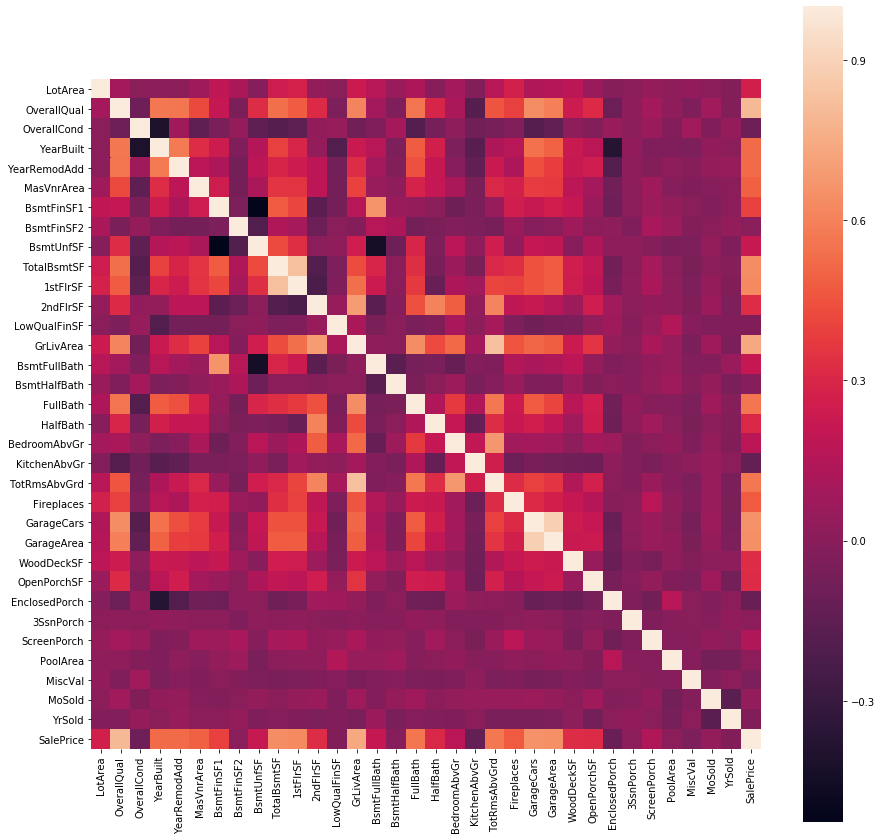

In [127]:
# Comprehensive correlation analysis 
corrmat = pd.concat([train_data[num_cols], train_y], axis = 1).corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, square=True)

### Bivariate analysis between numeric features and sale price.

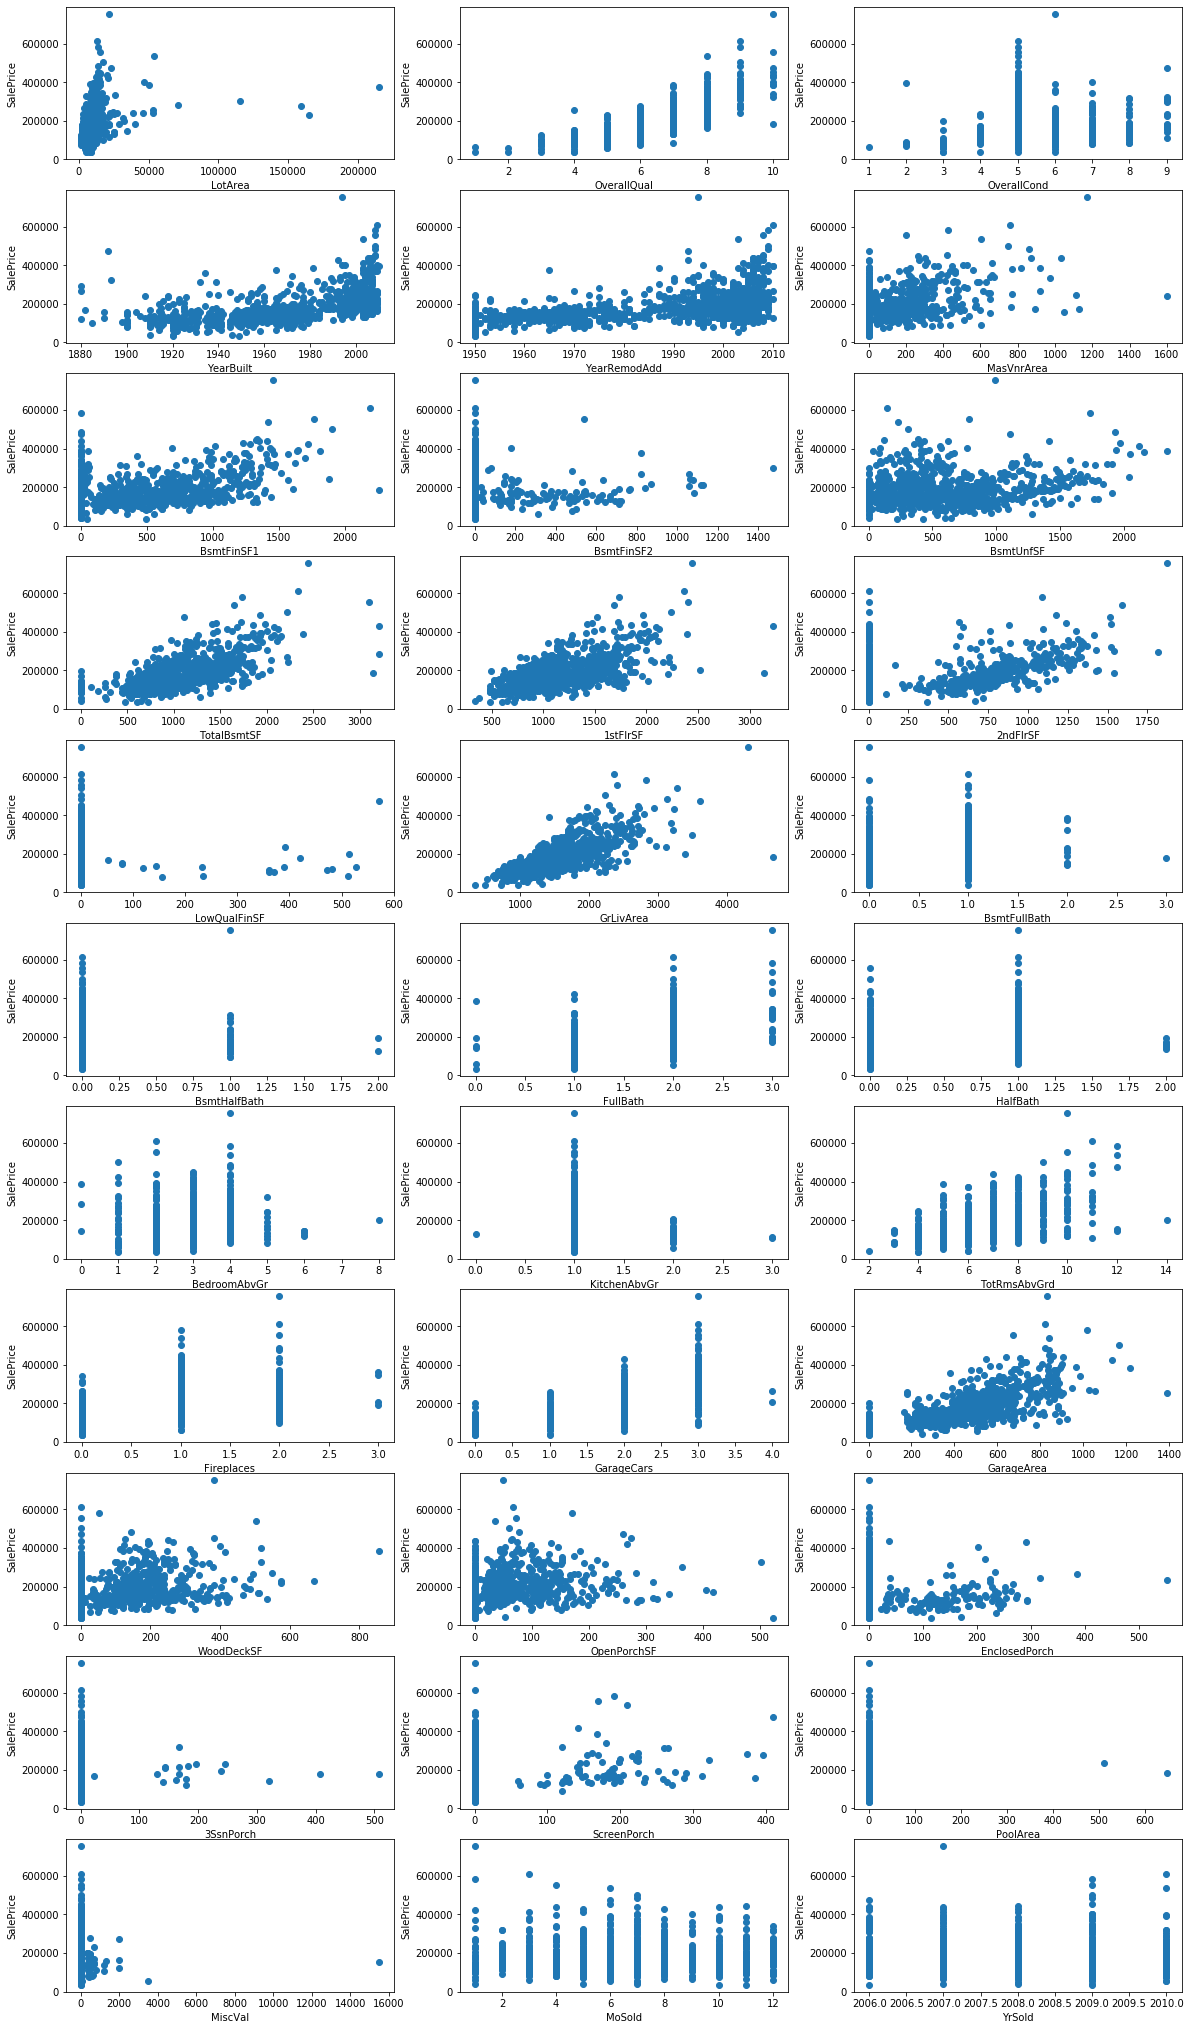

In [129]:
plt.figure(figsize=(20,50))
for idx,col in enumerate(num_cols):
    plt.subplot(15,3,idx+1)
    plt.scatter(x = train_data[col],y= train_y)
    plt.ylabel("SalePrice")
    plt.xlabel(col)

#### From the correlation matrix and the bivariate analysis above, we can tell that (1) some features are more strongly linearly correlated with sale price than the others; (2) the correlation between features can be fairly strong and (3) for the features not showing strong correlation with sale price, feature engineering may help reveal correlation based on the common sense.

### Feature selection and linear regression

In [141]:
# Use an arbitrary criteria of pearson's correlation larger than 0.5 to select features.
select_num_cols = []
print('Pearson correlation between features and sale price:')
for col in num_cols:
    corr, _ = pearsonr(train_data[col], train_y)
    print(col, ':', corr)
    if abs(corr) > 0.5: select_num_cols.append(col)
print(select_num_cols)

Pearson correlation between features and sale price:
LotArea : 0.26549322070754316
OverallQual : 0.7976658974197096
OverallCond : -0.09581575229152997
YearBuilt : 0.5271931928727536
YearRemodAdd : 0.5261947492983672
MasVnrArea : 0.4916087251823256
BsmtFinSF1 : 0.389867625380288
BsmtFinSF2 : 0.0003591698094213434
BsmtUnfSF : 0.22121923670510668
TotalBsmtSF : 0.6421266119769801
1stFlrSF : 0.6277490954920024
2ndFlrSF : 0.3253288362625248
LowQualFinSF : -0.028580460481146895
GrLivArea : 0.7349973806579476
BsmtFullBath : 0.2165657215882828
BsmtHalfBath : -0.009388620379388906
FullBath : 0.559979835097687
HalfBath : 0.30400803704977336
BedroomAbvGr : 0.1732866240593565
KitchenAbvGr : -0.13265366527956926
TotRmsAbvGrd : 0.5703750379696997
Fireplaces : 0.4730114966657964
GarageCars : 0.658203656304723
GarageArea : 0.6479528331764808
WoodDeckSF : 0.32495340681078816
OpenPorchSF : 0.3195510986890165
EnclosedPorch : -0.11171234439323444
3SsnPorch : 0.009682089684677805
ScreenPorch : 0.14074407434

In [139]:
lr = LinearRegression()
lr.fit(train_data[select_num_cols], train_y)
lr.score(train_data[select_num_cols], train_y)

0.8069126781407826

In [140]:
lr.score(dev_data[select_num_cols], dev_y)

0.67234931243297

### Feature engineering and linear regression

#### Although the feature of year sold doesn't show strong correlation with sale price, the house age plays an important role in buyer's purchase decision. Usually the newer a house is, the higher it can sell for. Accordingly, we can engineer two features to reveal the relevant information: (1) house age = year built - year sold and (2) remodel age = year remodel add - year sold.

In [143]:
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
dev_data['HouseAge'] = dev_data['YrSold'] - dev_data['YearBuilt']
train_data['RemodAge'] = train_data['YrSold'] - train_data['YearRemodAdd']
dev_data['RemodAge'] = dev_data['YrSold'] - dev_data['YearRemodAdd']

In [146]:
corr,_ = pearsonr(train_data['HouseAge'], train_y)
print('Pearson correlation between HouseAge and SalePrice:', corr)
corr,_ = pearsonr(train_data['RemodAge'], train_y)
print('Pearson correlation between RemodAge and SalePrice:', corr)

Pearson correlation between HouseAge and SalePrice: -0.5282916661847248
Pearson correlation between RemodAge and SalePrice: -0.5287991871334722


#### The feature month sold is quite interesting. It's not surpring to see weak correlation between it and sale price because summer is usually the best time for house sale. Therefore the relation between month sold and sale price is probably parabolic. We can engineer the feature of square of month sold to address it.

In [154]:
train_data['MoSoldSq'] = train_data['MoSold']**2
dev_data['MoSoldSq'] = dev_data['MoSold']**2

In [164]:
# Compose new data set with both the selected and the engineered numeric features.
train_data_num = pd.concat([train_data[select_num_cols],train_data['HouseAge'],train_data['RemodAge'],train_data['MoSold'],train_data['MoSoldSq']], axis = 1)
dev_data_num = pd.concat([dev_data[select_num_cols],dev_data['HouseAge'],dev_data['RemodAge'],dev_data['MoSold'],dev_data['MoSoldSq']], axis = 1)

In [165]:
lr = LinearRegression()
lr.fit(train_data_num, train_y)
lr.score(train_data_num, train_y)

0.807832705206126

In [166]:
lr.score(dev_data_num, dev_y)

0.6691625698998995